In [1]:
import pandas as pd, geopandas as gpd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "../../Shapefiles/Adminbdy Shapefile/"
#path = "C:/Users/Alexander/Downloads/adminbdy-shapefile/Adminbdy Shapefile"

# Use the read_file function to read the shapefile
union_council_gdf = gpd.read_file(f"{path}/Union_Council.shp")

# This will print the first few rows of the DataFrame
union_council_gdf['ID_uc'] = union_council_gdf.index
union_council_gdf.head(2)

,PROVINCE,DISTRICT,TEHSIL,UC,UC_C,Flood,Area,TOWN,U_R,PROVINCE_C,...,TEHSIL_C,UC_NAME,Data_Sourc,Level,School,New_Name,Shape_Leng,Shape_Area,geometry,ID_uc
0,Balochistan,Quetta,Zarghoon Town,Hanna (H-65),35044,None,13.900741,None,None,7,...,0,None,Alhasan,None,34.0,None,0.152171,0.001302,"POLYGON ((67.06208 30.24177, 67.06360 30.21792...",0
1,Balochistan,Quetta,Zarghoon Town,Nawa Killi (H-50),35057,None,18.406332,None,None,7,...,0,None,Alhasan,None,7.0,None,0.216025,0.001725,"POLYGON ((67.28795 30.21962, 67.27487 30.22649...",1


In [3]:
psu_closest_pos = pd.read_csv(r"../../psu_closest_pp_bl_gps.csv")
psu_closest_pos.head()

,id_distr_bank_psu,year,newid_ATM,min_dist_atm_osrm,newid,min_dist_pos_osrm,baseline_PSU,bank,min_dist_pp_osrm,period,...,district_str_opm,lat_psu,long_psu,more_10km,dist_pos_1_5_atm,pos_far_atm,more_100km_0,more_100km,latitude_pp,longitude_pp
0,204,2015,8952,5.614700,3185,12.3096,473,ALFALAH,5.614700,3,...,PESHAWAR,34.11726,71.591554,1,1,1,NaN,NaN,34.137009,71.505806
1,203,2015,8236,11.620200,3185,3.4645,472,ALFALAH,3.464500,3,...,PESHAWAR,34.13230,71.474948,0,0,0,NaN,NaN,34.137009,71.505806
2,206,2015,18375,1.119000,3186,4.7208,475,ALFALAH,1.119000,3,...,PESHAWAR,33.98967,71.478777,0,1,0,NaN,NaN,34.005886,71.501877
3,141,2015,11689,57.289501,3189,61.3615,582,ALFALAH,57.289501,3,...,LASBELA,25.42454,66.596739,1,0,0,NaN,NaN,25.005796,66.820107
4,140,2015,20413,1.164600,3191,0.7771,567,ALFALAH,0.777100,3,...,LASBELA,26.21699,66.317420,0,0,0,NaN,NaN,26.224617,66.312187


In [4]:
# Convert POS locations to GeoDataFrame
pos_gdf = gpd.GeoDataFrame(psu_closest_pos, 
                           geometry=gpd.points_from_xy(psu_closest_pos.longitude_pp, psu_closest_pos.latitude_pp))
pos_gdf.head(2)

,id_distr_bank_psu,year,newid_ATM,min_dist_atm_osrm,newid,min_dist_pos_osrm,baseline_PSU,bank,min_dist_pp_osrm,period,...,lat_psu,long_psu,more_10km,dist_pos_1_5_atm,pos_far_atm,more_100km_0,more_100km,latitude_pp,longitude_pp,geometry
0,204,2015,8952,5.6147,3185,12.3096,473,ALFALAH,5.6147,3,...,34.11726,71.591554,1,1,1,NaN,NaN,34.137009,71.505806,POINT (71.50581 34.13701)
1,203,2015,8236,11.6202,3185,3.4645,472,ALFALAH,3.4645,3,...,34.13230,71.474948,0,0,0,NaN,NaN,34.137009,71.505806,POINT (71.50581 34.13701)


In [5]:
pos_gdf.set_crs("EPSG:4326", inplace=True)

# Assuming `union_council_gdf` is your GeoDataFrame for union council
union_council_gdf = union_council_gdf.to_crs(pos_gdf.crs)

# Perform spatial join
joined_gdf = gpd.sjoin(pos_gdf, union_council_gdf, op='within', how='inner')
joined_gdf.head(2)

,id_distr_bank_psu,year,newid_ATM,min_dist_atm_osrm,newid,min_dist_pos_osrm,baseline_PSU,bank,min_dist_pp_osrm,period,...,DISTRICT_C,TEHSIL_C,UC_NAME,Data_Sourc,Level,School,New_Name,Shape_Leng,Shape_Area,ID_uc
0,204,2015,8952,5.6147,3185,12.3096,473,ALFALAH,5.6147,3,...,219,21901,Chaghar Matti,Alhasan,2,0.0,None,0.238561,0.001603,394
1,203,2015,8236,11.6202,3185,3.4645,472,ALFALAH,3.4645,3,...,219,21901,Chaghar Matti,Alhasan,2,0.0,None,0.238561,0.001603,394


<Axes: >

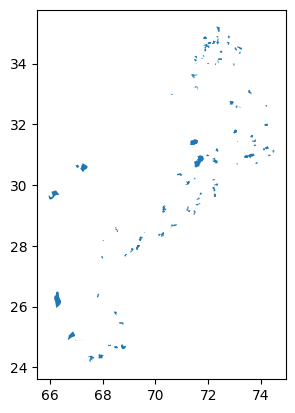

In [6]:
joined_gdf_2 = joined_gdf.drop_duplicates(subset=['baseline_PSU', 'newid'])
joined_gdf_2 = joined_gdf_2.merge(union_council_gdf[['ID_uc', 'geometry']], on = "ID_uc")
joined_gdf_2 = joined_gdf_2.set_geometry("geometry_y")
joined_gdf_2.plot()

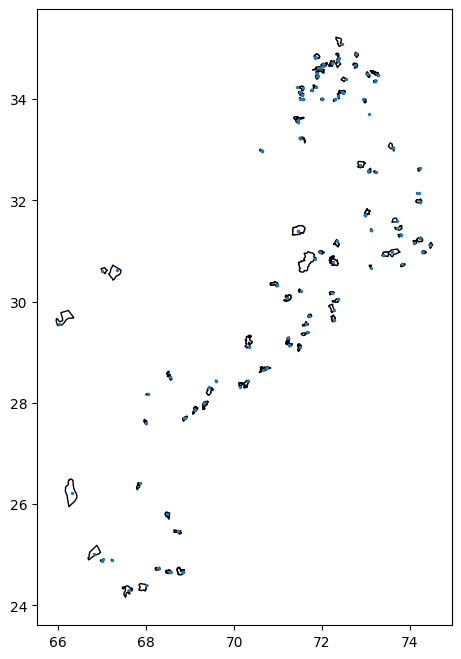

In [7]:
fix, ax = plt.subplots(figsize=(8, 8))
joined_gdf_2.plot(ax=ax, color = 'white', edgecolor='black')
pos_gdf.plot(ax=ax, markersize=2)
plt.show()

In [8]:
id_columns = ['index', 'id_distr_bank_psu', 'year', 'newid', 'baseline_PSU', joined_gdf_2.geometry.name]
joined_gdf_2 = joined_gdf_2.reset_index()
joined_gdf_2[id_columns].to_file("../data/0_shapefile/pos_gdf.shp")